In [7]:
#mport warnings
#arnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import modules
import os
import math

# deep learning modules
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.special import gammaln


# Useful tool(s)
from tqdm.notebook import tqdm

import scipy.stats as stats
from scipy.integrate import odeint


from utils import *

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: {}".format(device))

device: cuda:0


In [11]:
data_dir = "data/"
model_dir = "model/"

data_name = "strongly_bimodal" # write down your data in the second string
save_file_name = data_name   # 
K = 4
h = 16
M=80 ## number of kernel
s_min = 0.5
s_max = 2

n_col_pts = 100
n_sample_g = 60

In [12]:
obs_time, time_trace, scaled_trace, mean_scaled_trace = data_preprocessing(data_name, data_dir, device)

In [13]:
initial_time = obs_time[0].item()
final_time = obs_time[-1].item()

In [14]:
net_MDN, loss_log = torch.load(model_dir+save_file_name, map_location=device)
net_MDN.device = device

In [15]:
net_MDN.data = mean_scaled_trace.repeat(n_sample_g,1,1)

mu, log_var = net_MDN.encoder()

net_MDN.z = net_MDN.reparameterization(mu, log_var)

In [16]:
col_time = torch.linspace(int(initial_time), int(final_time), n_col_pts+1).to(device).reshape(-1,1)
t_v = Variable(col_time, requires_grad = True).repeat(net_MDN.data.size()[0],1,1)
t_np = ten_to_npy(col_time).reshape(-1)
_, cdf_g, y = net_MDN(t_v)
pdf_g = cal_der(cdf_g, t_v, device)[:,:,0].view(cdf_g.size())
lb, ld = net_MDN.pred_lmda()#.item()#[:,:,1].item()

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


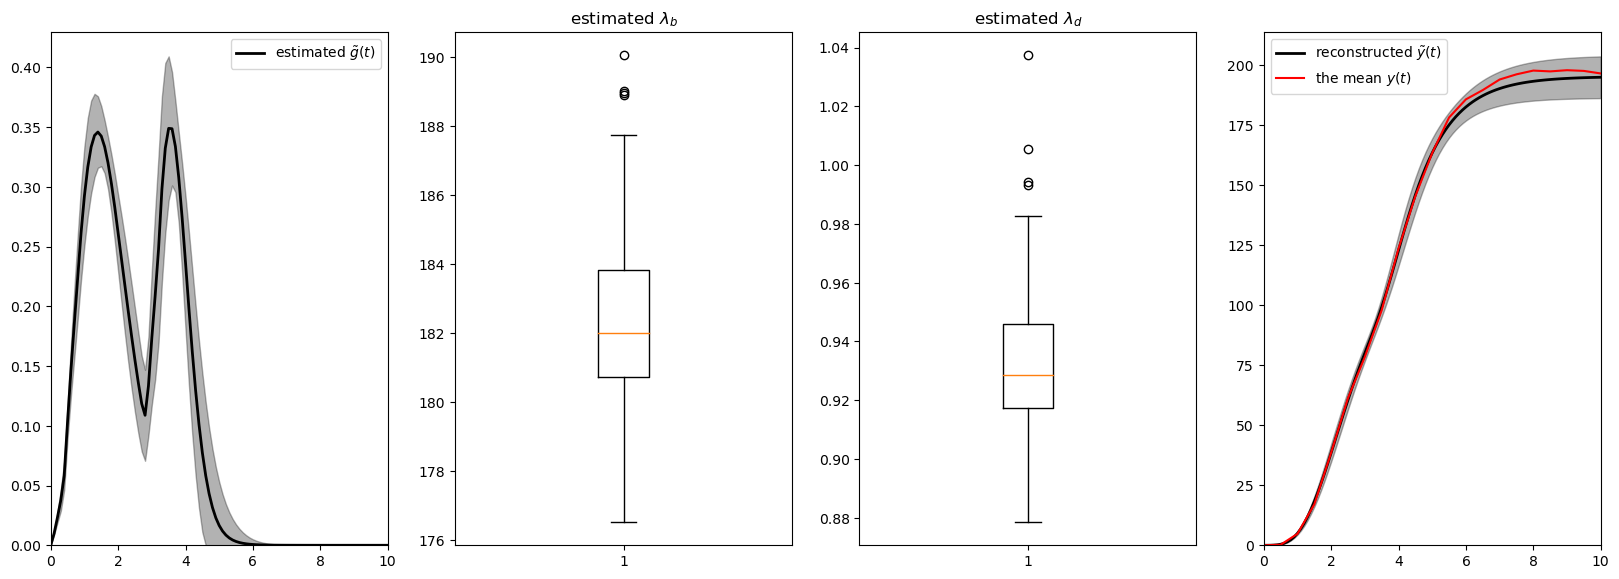

In [17]:
y_list = ten_to_npy(y)
pdf_list = ten_to_npy(pdf_g)
lb_list = ten_to_npy(lb).reshape(-1,1)
ld_list = ten_to_npy(ld).reshape(-1,1)

y_m = y_list.mean(axis=0).reshape(-1)
y_std = 1.96*y_list.std(axis=0).reshape(-1)
g_m = pdf_list.mean(axis=0).reshape(-1)
g_std = 1.96*pdf_list.std(axis=0).reshape(-1)

fig = plt.figure(figsize=(20,20/3))
#fig.suptitle("dist_type:{}, # traj:{}, iteration: {}".format(t_type, mean_ntraj, int(w_t_np[-1]*1000)),y=0.95, fontsize=16)
true_y = ten_to_npy(time_trace)
true_y = true_y.mean(axis=0)
obs_t = ten_to_npy(obs_time).reshape(-1)

ax = fig.add_subplot(141)
ax.plot(t_np, g_m, c='black', linewidth=2, alpha = 1, label=r"estimated $\tilde{g}(t)$")
ax.fill_between(t_np, g_m+g_std, np.clip(g_m-g_std, a_min=0, a_max=None), color = 'black', alpha = 0.3)
ax.set_xlim([initial_time,final_time])
ax.set_ylim([initial_time,None])
ax.legend()

ax = fig.add_subplot(142)
ax.boxplot(lb_list)
ax.set_title(r"estimated $\lambda_b$")

ax = fig.add_subplot(143)
ax.boxplot(ld_list)
ax.set_title(r"estimated $\lambda_d$")

ax = fig.add_subplot(144)
#for k in range(len(true_y)):
#    ax.plot(obs_t,true_y[k].reshape(-1), color='blue')
ax.plot(t_np, y_m, c='black', linewidth=2, alpha = 1, label=r"reconstructed $\tilde{y}(t)$")
ax.plot(ten_to_npy(obs_time.view(-1)),ten_to_npy(time_trace.mean(axis=0).view(-1)), c='r', label=r"the mean $y(t)$")
ax.fill_between(t_np, y_m+y_std, np.clip(y_m-y_std, a_min=0, a_max=None), color = 'black', alpha = 0.3)
ax.set_xlim([initial_time,final_time])
ax.set_ylim([initial_time,None])
ax.legend()


plt.savefig("figure/estimation_{}.jpg".format(data_name), bbox_inches='tight', dpi=300)
plt.show()